# __Dense matrix tests__

## Outline
- __Dependencies__
- __Dynamic ansatz__
    - Noiseless
    - With noise using Qiskit AER
- __Static ansatz__
    - Noiseless
    - With noise using Qiskit AER

In [7]:
import numpy as np
from device_var_lse_solver import DeviceVarLSESolver
from device import DeviceType
from conditioned_matrix import conditionedMatrix
from non_dynamical_ansatz import fixed_layered_ansatz
from tqdm import tqdm
from device import Device

qubits = 4
b = np.ones(2**qubits)/np.sqrt(2**qubits)
depth=10

assert qubits % 2 == 0

In [8]:
# As defined by [10]
def TRC_ADA(iteration_count : dict):
    trc = 0
    for d in iteration_count:
        z = iteration_count.get(d)
        trc += d*z
    return trc

def TRC_ASA(iteration_count : dict):
    trc = 0
    max_size = max(iteration_count)
    for d in iteration_count:
        z = iteration_count.get(d)
        trc += z*max_size
    print(max_size)
    return trc

## __Dynamic ansatz__

In [ ]:
# For poisson matrix
N_runs = 10
N_steps = 1000
max_c = 20
redo_calc = 10

cs = [2*i+1 for i in range(int(max_c/2))]

local_noiseless_dynamic_trc = np.zeros((redo_calc, len(cs)))
global_noiseless_dynamic_trc = np.zeros((redo_calc, len(cs)))
local_noise_dynamic_trc = np.zeros((redo_calc, len(cs)))
global_noise_dynamic_trc = np.zeros((redo_calc, len(cs)))

local_noiseless_static_trc = np.zeros((redo_calc, len(cs)))
global_noiseless_static_trc = np.zeros((redo_calc, len(cs)))
local_noise_static_trc = np.zeros((redo_calc, len(cs)))
global_noise_static_trc = np.zeros((redo_calc, len(cs)))

local_noise_dynamic_error = np.zeros((redo_calc, len(cs)))
local_noiseless_dynamic_error = np.zeros((redo_calc, len(cs)))
local_noise_static_error = np.zeros((redo_calc, len(cs)))
local_noiseless_static_error = np.zeros((redo_calc, len(cs)))

global_noise_dynamic_error = np.zeros((redo_calc, len(cs)))
global_noiseless_dynamic_error = np.zeros((redo_calc, len(cs)))
global_noise_static_error = np.zeros((redo_calc, len(cs)))
global_noiseless_static_error = np.zeros((redo_calc, len(cs)))

device = Device(DeviceType.QISKIT_AER, qubits=qubits)

param_shape = (qubits + depth*(qubits+qubits -2),)

for i in range(redo_calc):
        print(f"Run nr. {i+1}/{redo_calc}")
        for j, c in enumerate(tqdm(cs)):
                a = conditionedMatrix(2**qubits, c)
                classical_solution = np.linalg.solve(a, b)
                normalized_classical_solution = np.square(classical_solution / np.linalg.norm(classical_solution))
                normalized_classical_solution /= np.linalg.norm(normalized_classical_solution)

                ###################################
                #####    DYNAMIC NOISELESS    #####
                ###################################
                lse_local = DeviceVarLSESolver(a,
                        b, 
                        method='direct',
                        local=True, 
                        lr=0.1, 
                        steps=N_steps,
                        threshold=0.001, 
                        epochs=N_runs,
                        silent=True)
                
                lse_global = DeviceVarLSESolver(a,
                        b, 
                        method='direct',
                        local=False, 
                        lr=0.1, 
                        steps=N_steps,
                        threshold=0.001, 
                        epochs=N_runs,
                        silent=True)
        
                solution_local, param_local, it_count_local = lse_local.solve()
                solution_global, param_global, it_count_global = lse_global.solve()
                solution_local /= np.linalg.norm(solution_local)
                solution_global /= np.linalg.norm(solution_global)

                local_noiseless_dynamic_trc[i, j] = TRC_ADA(it_count_local)
                global_noiseless_dynamic_trc[i, j] = TRC_ADA(it_count_global)

                local_noiseless_dynamic_error[i, j] = np.linalg.norm(solution_local - np.abs(normalized_classical_solution))
                global_noiseless_dynamic_error[i, j] = np.linalg.norm(solution_global - np.abs(normalized_classical_solution))
        
                ###################################
                #####    DYNAMIC NOISEFULL    #####
                ###################################
                lse_local = DeviceVarLSESolver(a,
                        b, 
                        method='direct',
                        local=True, 
                        lr=0.1, 
                        steps=N_steps,
                        threshold=0.001, 
                        epochs=N_runs,
                        device=device,
                        silent=True)
                
                lse_global = DeviceVarLSESolver(a,
                        b, 
                        method='direct',
                        local=False, 
                        lr=0.1, 
                        steps=N_steps,
                        threshold=0.001, 
                        epochs=N_runs,
                        device=device,
                        silent=True)
        
                solution_local, param_local, it_count_local = lse_local.solve()
                solution_global, param_global, it_count_global = lse_global.solve()

                local_noise_dynamic_trc[i, j] = TRC_ADA(it_count_local)
                global_noise_dynamic_trc[i, j] = TRC_ADA(it_count_global)

                local_noise_dynamic_error[i, j] = np.linalg.norm(solution_local - np.abs(normalized_classical_solution))
                global_noise_dynamic_error[i, j] = np.linalg.norm(solution_global - np.abs(normalized_classical_solution))

                ###################################
                #####    STATIC  NOISELESS    #####
                ###################################
                lse_local = DeviceVarLSESolver(a,
                        b, 
                        method='direct',
                        ansatz=fixed_layered_ansatz,
                        weights=param_shape,
                        local=True, 
                        lr=0.1, 
                        steps=N_steps,
                        threshold=0.001, 
                        epochs=N_runs,
                        silent=True)
                
                lse_global = DeviceVarLSESolver(a,
                        b, 
                        method='direct',
                        ansatz=fixed_layered_ansatz,
                        weights=param_shape,
                        local=False, 
                        lr=0.1, 
                        steps=N_steps,
                        threshold=0.001, 
                        epochs=N_runs,
                        silent=True)
        
                solution_local, param_local, it_count_local = lse_local.solve()
                solution_global, param_global, it_count_global = lse_global.solve()

                local_noiseless_static_trc[i, j] = TRC_ADA(it_count_local)
                global_noiseless_static_trc[i, j] = TRC_ADA(it_count_global)

                local_noiseless_static_error[i, j] = np.linalg.norm(solution_local - np.abs(normalized_classical_solution))
                global_noiseless_static_error[i, j] = np.linalg.norm(solution_global - np.abs(normalized_classical_solution))

                ###################################
                #####    STATIC  NOISEFULL    #####
                ###################################
                lse_local = DeviceVarLSESolver(a,
                        b, 
                        method='direct',
                        local=True, 
                        ansatz=fixed_layered_ansatz,
                        weights=param_shape,
                        lr=0.1, 
                        steps=N_steps,
                        threshold=0.001, 
                        epochs=N_runs,
                        device=device,
                        silent=True)
                
                lse_global = DeviceVarLSESolver(a,
                        b, 
                        method='direct',
                        local=False, 
                        ansatz=fixed_layered_ansatz,
                        weights=param_shape,
                        lr=0.1, 
                        steps=N_steps,
                        threshold=0.001, 
                        epochs=N_runs,
                        device=device,
                        silent=True)
        
                solution_local, param_local, it_count_local = lse_local.solve()
                solution_global, param_global, it_count_global = lse_global.solve()

                local_noise_static_trc[i, j] = TRC_ADA(it_count_local)
                global_noise_static_trc[i, j] = TRC_ADA(it_count_global)

                local_noise_static_error[i, j] = np.linalg.norm(solution_local - np.abs(normalized_classical_solution))
                global_noise_static_error[i, j] = np.linalg.norm(solution_global - np.abs(normalized_classical_solution))

Run nr. 1/1


100%|██████████| 1/1 [00:56<00:00, 56.31s/it]


In [10]:
import matplotlib.pyplot as plt

# Dynamic noisless
local_noiseless_dynamic_mean = np.mean(local_noiseless_dynamic_trc, axis=0)
local_noiseless_dynamic_variance = np.var(local_noiseless_dynamic_trc, axis=0)

global_noiseless_dynamic_mean = np.mean(global_noiseless_dynamic_trc, axis=0)
global_noiseless_dynamic_variance = np.var(global_noiseless_dynamic_trc, axis=0)

# Dynamic noisfull
local_noise_dynamic_mean = local_noise_dynamic_trc.mean()
local_noise_dynamic_variance = local_noise_dynamic_trc.var()

global_noise_dynamic_mean = global_noise_dynamic_trc.mean()
global_noise_dynamic_variance = global_noise_dynamic_trc.var()

# Static noisless
local_noiseless_static_mean = np.mean(local_noiseless_static_trc, axis=0)
local_noiseless_static_variance = np.var(local_noiseless_static_trc, axis=0)

global_noiseless_static_mean = np.mean(global_noiseless_static_trc, axis=0)
global_noiseless_static_variance = np.var(global_noiseless_static_trc, axis=0)

# Static noisfull
local_noise_static_mean = local_noise_static_trc.mean()
local_noise_static_variance = local_noise_static_trc.var()

global_noise_static_mean = global_noise_static_trc.mean()
global_noise_static_variance = global_noise_static_trc.var()

## __Save vals__

In [11]:
## Save the vals

## __Plot?__

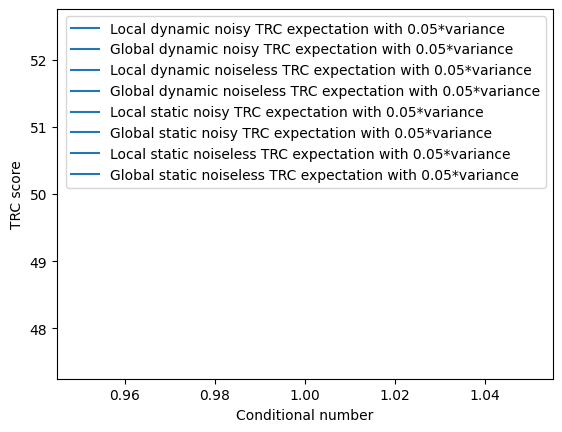

In [12]:
amp = 0.05

# Dynamic noisy
local_dynamic_noise_color = "tab:blue"
plt.plot(cs, local_noise_dynamic_mean, color=local_dynamic_noise_color, label=f'Local dynamic noisy TRC expectation with {amp}*variance')
plt.fill_between(cs, local_noise_dynamic_mean-amp*local_noise_dynamic_variance, local_noise_dynamic_mean+amp*local_noise_dynamic_variance, color=local_dynamic_noise_color, alpha=0.4)

global_dynamic_noise_color = "tab:blue"
plt.plot(cs, global_noise_dynamic_mean, color=global_dynamic_noise_color, label=f'Global dynamic noisy TRC expectation with {amp}*variance')
plt.fill_between(cs, global_noise_dynamic_mean-amp*global_noise_dynamic_variance, global_noise_dynamic_mean+amp*global_noise_dynamic_variance, color=global_dynamic_noise_color, alpha=0.4)

# Dynamic noiseless
local_dynamic_noiseless_color = "tab:blue"
plt.plot(cs, local_noiseless_dynamic_mean, color=local_dynamic_noiseless_color, label=f'Local dynamic noiseless TRC expectation with {amp}*variance')
plt.fill_between(cs, local_noiseless_dynamic_mean-amp*local_noiseless_dynamic_variance, local_noiseless_dynamic_mean+amp*local_noiseless_dynamic_variance, color=local_dynamic_noiseless_color, alpha=0.4)

global_dynamic_noiseless_color = "tab:blue"
plt.plot(cs, global_noiseless_dynamic_mean, color=global_dynamic_noiseless_color, label=f'Global dynamic noiseless TRC expectation with {amp}*variance')
plt.fill_between(cs, global_noiseless_dynamic_mean-amp*global_noiseless_dynamic_variance, global_noiseless_dynamic_mean+amp*global_noiseless_dynamic_variance, color=global_dynamic_noiseless_color, alpha=0.4)

# Static noisy
local_static_noise_color = "tab:blue"
plt.plot(cs, local_noise_static_mean, color=local_static_noise_color, label=f'Local static noisy TRC expectation with {amp}*variance')
plt.fill_between(cs, local_noise_static_mean-amp*local_noise_static_variance, local_noise_static_mean+amp*local_noise_static_variance, color=local_static_noise_color, alpha=0.4)

global_static_noise_color = "tab:blue"
plt.plot(cs, global_noise_static_mean, color=global_static_noise_color, label=f'Global static noisy TRC expectation with {amp}*variance')
plt.fill_between(cs, global_noise_static_mean-amp*global_noise_static_variance, global_noise_static_mean+amp*global_noise_static_variance, color=global_static_noise_color, alpha=0.4)

# Static noiseless
local_static_noiseless_color = "tab:blue"
plt.plot(cs, local_noiseless_static_mean, color=local_static_noiseless_color, label=f'Local static noiseless TRC expectation with {amp}*variance')
plt.fill_between(cs, local_noiseless_static_mean-amp*local_noiseless_static_variance, local_noiseless_static_mean+amp*local_noiseless_static_variance, color=local_static_noiseless_color, alpha=0.4)

global_static_noiseless_color = "tab:blue"
plt.plot(cs, global_noiseless_static_mean, color=global_static_noiseless_color, label=f'Global static noiseless TRC expectation with {amp}*variance')
plt.fill_between(cs, global_noiseless_static_mean-amp*global_noiseless_static_variance, global_noiseless_static_mean+amp*global_noiseless_static_variance, color=global_static_noiseless_color, alpha=0.4)

#############################

plt.xlabel("Conditional number")
plt.ylabel("TRC score")

plt.legend()
plt.show()